# Load features and targets

In [1]:
# load features
import pickle
features = pickle.load( open( "Onehotfeatures.pkl", "rb" ) )

# load associated targets
from numpy import load
y = load('target.npy')

Choose features and prepare data for scikit-learn prototyping

In [2]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(features.get(f, 'Feature not present') for f in imp_feature)

In [3]:
from scipy.sparse import hstack
X = hstack( X_features )
X.shape, type(X)

((550071, 9996), scipy.sparse.coo.coo_matrix)

# Stacking Ridge and GBRT

Here we will use Ridge and GBRT to predict purchase. From those two outputs, we will make a blender to give us a single purchase prediction. Using Ridge and GBRT is a good choice because there are making different type of mistakes. Stacking both will yield better performance.

Split training set in two parts (One for training Ridge and GBRT and the other to make prediction that will serve as 'clean' features for our blender)

In [4]:
# split training set in two
from sklearn.model_selection import train_test_split
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=4)

Load Ridge and GRBT models

In [5]:
from sklearn.externals import joblib
gbrt_stack = joblib.load('./models/GBRT_Model.pkl')
ridge_stack = joblib.load('./models/Ridge_Model.pkl')

Re-train Ridge and GBRT on training data 1st half

In [6]:
ridge_stack.fit(X_1, y_1)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='sag', tol=0.001)

In [8]:
# make sure it starts over (GBRT optimization had warm_start True)
gbrt_stack.warm_start = False
gbrt_stack.fit(X_1, y_1)

      Iter       Train Loss      OOB Improve   Remaining Time 


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=925,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=499,
             presort='auto', random_state=29, subsample=0.8, verbose=1,
             warm_start=True)

Save new Ridge and GBRT models

In [10]:
joblib.dump(gbrt_stack, './models/GBRT_Stack_Model.pkl')
joblib.dump(ridge_stack, './models/Ridge_Stack_Model.pkl')

['./models/Ridge_Stack_Model.pkl']

Make predictions on 2nd half

In [11]:
# Ridge and GBRT predictions on 2nd half
gbrt_pred = gbrt_stack.predict(X_2)
ridge_pred = ridge_stack.predict(X_2)
# stack predictions together
import numpy as np
X_blender = np.stack((gbrt_pred, ridge_pred), axis=1)

Parameter grid for grid search

In [12]:
# values for parameter grid
alpha_arr = np.array([ 10**x for x in range(-2,1)])
alpha_arr = np.concatenate([alpha_arr, 3*alpha_arr])
# parameter grid
param_grid_model_blr = [ {'alpha': alpha_arr} ]
param_grid_model_blr

[{'alpha': array([ 0.01,  0.1 ,  1.  ,  0.03,  0.3 ,  3.  ])}]

Create Blender (Ridge) and do a grid search

In [13]:
# train blender
from sklearn.linear_model import Ridge
model_blr = Ridge( random_state=29, solver='svd')

# polynomial features
# NOTE: no need to do feature scaling since ridge is a closed-form
from sklearn.preprocessing import PolynomialFeatures
polystack = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_blender_poly = polystack.fit_transform(X_blender)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
model_blr_grid = GridSearchCV(model_blr, param_grid_model_blr, cv = cv,\
                              scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)

# run grid search
model_blr_grid.fit( X_blender_poly , y_2 )

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=4, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='svd', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'alpha': array([ 0.01,  0.1 ,  1.  ,  0.03,  0.3 ,  3.  ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

Performance result on cross-validation

In [14]:
# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-model_blr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-model_blr_grid.best_score_)) )
print(model_blr_grid.best_estimator_)

MSE, best param, mean cross-val = 5919410.2023
RMSE, best param, mean cross-val = 2432.9838
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='svd', tol=0.001)


Performance on entire training set

In [17]:
# metrics on entire dataset, must be higher that Xval scores
y_pred = model_blr_grid.predict(X_blender_poly)
from sklearn.metrics import mean_squared_error
print('\nMSE (whole training set) = {:.4f}'.format(mean_squared_error(y_2, y_pred)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y_2, y_pred))))


MSE (whole training set) = 5927599.6208
RMSE (whole training set) = 2434.6662


### Are mistakes made by GBRT and Ridge really different?
Spolier alert: yes!

<IPython.core.display.Javascript object>


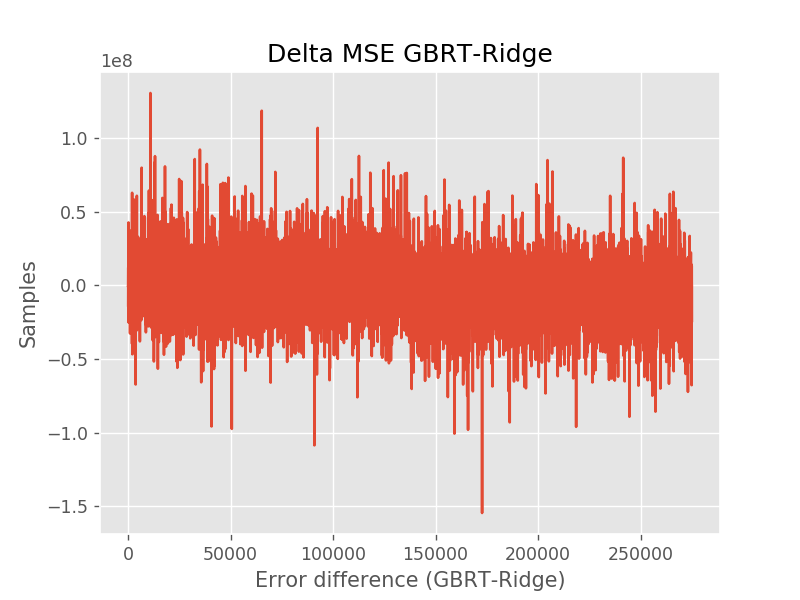

5012745.61161


In [18]:
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# plot errors for gbrt and ridge
_, axsterr = plt.subplots()
stack_error = (gbrt_pred-y_2)**2 - (ridge_pred-y_2)**2
axsterr.plot(stack_error)
# add title and axes labels
axsterr.set_title('Delta MSE GBRT-Ridge')
axsterr.set_xlabel('Error difference (GBRT-Ridge)')
axsterr.set_ylabel('Samples')

print(np.std(stack_error))

In [ ]:
# try decision tree blender instead of Ridge

# Run model on test set

Read test set in memory and recover encoders from file and derive one-hot encoded features

In [19]:
from utils import fextract as ft
import pandas as pd
import pickle
import importlib

filename = './test_HujdGe7/test.csv'
df_test = pd.read_csv(filename)

# Load encoders
encoders = pickle.load( open( "Onehotencoders.pkl", "rb" ) )
catcoders = pickle.load( open( "Category_encoders.pkl", "rb" ) )

# reload is necessary if one makes changes in fextract. Indeed modules are loaded once only, this forces a reload.
importlib.reload(ft)

# get one-hot encoded features and their names
features_test = ft.prepare_Data(df_test, (catcoders, encoders))

Select necessary features (must match your feature model obviously)

In [20]:
X_features_test = tuple(f[0] for f in features_test if f[1] in imp_feature)
X_test = hstack( X_features_test )
# check shape
X_test.shape

(233599, 9996)

Make predictions and save them to file

In [ ]:
gbrt_pred_test = gbrt_stack.predict(X_test)
ridge_pred_test = ridge_stack.predict(X_test)
# stack predictions together
X_blender_test = np.stack((gbrt_pred_test, ridge_pred_test), axis=1)

# get final predictions
X_blender_poly_test = polystack.transform(X_blender_test)
y_pred_test = model_blr_grid.predict(X_blender_poly_test)

# format result save to csv for submission
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
df_results.to_csv('./submissions/Submission_Stacking.csv', index=False)